In [1]:
import ee 
import shapely as shp
import pandas as pd
import numpy as np
import geopandas as gpd
import ast
from shapely.geometry import Polygon, MultiPolygon, Point

In [28]:
import ee

# Trigger the authentication flow.
#ee.Authenticate()

# Initialize the library.
ee.Initialize()


In [292]:
basins = ee.FeatureCollection("WWF/HydroSHEDS/v1/Basins/hybas_9");
basinsall = basins
image = ee.Image('WWF/HydroSHEDS/03VFDEM');

a = pd.read_csv('a.csv')

In [174]:
## I now have the p & b basins delineated, I think
geoms = gpd.read_file('basins_final')
features = []
for i,row in geoms.iterrows():
    x = row.geometry.exterior.coords.xy[0]
    y = row.geometry.exterior.coords.xy[1]
    lonlat = [[xi,yi] for xi,yi in zip(x,y)]
    features.append(ee.Feature(ee.Geometry.Polygon(lonlat)).set('id',row['id']))
    


In [198]:
dp = int(len(features)/8)
feats=[]
for i in range(8):
    feats.append(ee.FeatureCollection(features[int(i*dp):int((i+1)*dp)]))
#begin dp 2*dp 2.5*dp 3*dp end

In [178]:
feats

In [109]:
def numberOfPixels(img):
    imgDescription = ee.Algorithms.Describe( img )
    height = ee.List( ee.Dictionary( ee.List(  ee.Dictionary( imgDescription ).get("bands") ).get(0) ).get("dimensions") ).get(0);
    width = ee.List( ee.Dictionary( ee.List(  ee.Dictionary( imgDescription ).get("bands") ).get(0) ).get("dimensions") ).get(1);
  
    print("width", width.getInfo() )
    print("height", height.getInfo() )
  
    return  ee.Number( width ).multiply( ee.Number( height ) ).getInfo()


In [110]:
geom = pd.read_csv('a.csv')
geom = geom.sort_values('Latitude (decimal degrees)')
latlon = [[i,j] for [i,j] in zip(geom['Longitude (decimal degrees)'].values,
                              geom['Latitude (decimal degrees)'].values)][:-1]
c=0
for i in latlon[1:400]:
    if (np.isnan(i[0]))|(np.isnan(i[1])):
        latlon.pop(c)
    c+=1

In [111]:
pts = ee.Geometry.MultiPoint(latlon)

In [275]:
#basins = ee.FeatureCollection(basins)
#basins = basins.merge(basins2)
import matplotlib.pyplot as plt

In [32]:
myImage = image.clip(ee.FeatureCollection(basins.first().geometry()))

NameError: name 'image' is not defined

In [270]:
None


In [33]:
drainageDirectionVis = {
  'min': 0.0,
  'max': 2000,
  }

In [236]:
#def meanDictionary(geom):
    #def featurescount(feature):
        #return feature
#a = image.reduceRegions(basins,ee.Reducer.mean());
for num in range(8):
    image2 = ee.Terrain.aspect(image)
    b = image2.reduceRegions(basins,ee.Reducer.percentile([20, 50, 80, 95]))
    b2 = image2.reduceRegions(feats[num],ee.Reducer.mean())
        #return a.filter(ee.Filter.notNull(['mean'])).map(featurescount)
    #b = basins.map(meanDictionary)
    mytask = ee.batch.Export.table.toDrive(collection=b2, folder='data_earth_engine', description='basins_aspect_means_'+str(num), fileFormat='CSV')

    mytask.start()

In [200]:
mytask.active()

False

In [296]:
def rm_geom(feature):
    feature = feature.setGeometry(None)
    return feature

b2=b2.map(rm_geom)

In [340]:
b

,system:index,COAST,DIST_MAIN,DIST_SINK,ENDO,HYBAS_ID,MAIN_BAS,NEXT_DOWN,NEXT_SINK,ORDER,PFAF_ID,SORT,SUB_AREA,UP_AREA,mean,.geo,NEXT_UP
0,00000000000000000001,0,10.1,10.1,0,2090644710,2090017320,2090017320,2090017320,1,216050430,12628,155.0,2535.7,364.664868,"{""type"":""Polygon"",""coordinates"":[[[-0.35416858...","[2090643100, 2090642990, 2090642360, 209064209..."
1,00000000000000000002,0,10.1,10.1,0,2090644510,2090017320,2090017320,2090017320,2,216050421,12629,123.2,1523.2,214.686357,"{""type"":""Polygon"",""coordinates"":[[[-0.25478414...","[2090642210, 2090642200, 2090640400, 209064070..."
2,00000000000000000003,0,27.0,27.0,0,2090642210,2090017320,2090644510,2090017320,2,216050423,12630,101.3,1248.6,355.033959,"{""type"":""Polygon"",""coordinates"":[[[-0.20833363...","[2090640400, 2090640700, 2090638820, 209063877..."
3,00000000000000000004,0,27.0,27.0,0,2090642200,2090017320,2090644510,2090017320,3,216050422,12631,151.5,151.6,745.204998,"{""type"":""Polygon"",""coordinates"":[[[-0.36306891...",[]
4,00000000000000000005,0,39.7,39.7,0,2090640400,2090017320,2090642210,2090017320,2,216050425,12632,46.5,954.9,365.145831,"{""type"":""Polygon"",""coordinates"":[[[-0.12083271...","[2090638820, 2090638770, 2090636040, 2090636050]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508185,001000000000000035ee,1,0.0,0.0,0,6090040190,6090040190,0,6090040190,0,673000050,60616,627.8,627.8,178.638380,"{""type"":""MultiPolygon"",""coordinates"":[[[[-90.8...",[]
508186,001000000000000035ef,1,0.0,0.0,0,6090040280,6090040280,0,6090040280,0,673000073,60620,440.8,440.8,73.030976,"{""type"":""MultiPolygon"",""coordinates"":[[[[-90.8...",[]
508187,001000000000000035f0,1,0.0,0.0,0,6090040320,6090040320,0,6090040320,0,673000075,60622,872.6,872.6,310.911204,"{""type"":""Polygon"",""coordinates"":[[[-91.5160394...",[]
508188,001000000000000035f1,1,0.0,0.0,0,6090040380,6090040380,0,6090040380,0,673000077,60624,432.3,432.3,208.277812,"{""type"":""Polygon"",""coordinates"":[[[-91.3833321...",[]


In [341]:
b.index = b['HYBAS_ID']
bboxs = []
for i,row in b.iterrows():
    geom = np.squeeze(json.loads(row['.geo'])['coordinates'])
    try:
        p = Polygon(geom)
    except:
        try:
            p = Polygon(np.squeeze(geom[0]))
        except:
            p = Polygon(np.squeeze(geom[0][0]))
    bboxs.append(p.bounds[i])


/Users/gr_1/opt/miniconda3/envs/ee/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [390]:
b.to_pickle('BASINS_n')

(array([  2861.,   2315.,    838.,   1323.,    799.,   1340.,   5251.,
         36656.,  85558., 106000.,  92802.,  63952.,  41880.,  26504.,
         17028.,   9978.,   6248.,   3852.,   1951.,   1054.]),
 array([-2.38042444e+00, -2.18224308e+00, -1.98406172e+00, -1.78588036e+00,
        -1.58769900e+00, -1.38951764e+00, -1.19133628e+00, -9.93154920e-01,
        -7.94973560e-01, -5.96792200e-01, -3.98610840e-01, -2.00429480e-01,
        -2.24811992e-03,  1.95933240e-01,  3.94114600e-01,  5.92295960e-01,
         7.90477320e-01,  9.88658680e-01,  1.18684004e+00,  1.38502140e+00,
         1.58320276e+00]),
 <BarContainer object of 20 artists>)

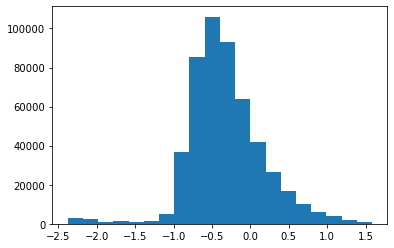

In [398]:
plt.hist(np.log10(b['maxy']-b['miny']),20)

## start

In [374]:
hy

6

In [ ]:
def meanDictionary(geom):
    return image.clip(geom.geometry())
mns = basins.map(meanDictionary)

In [ ]:
basins.getInfo()

In [283]:
import matplotlib.pyplot as plt

In [172]:

import json 
from shapely.geometry import Polygon
basin_slopes = gpd.GeoDataFrame()
basin_slopes_t = gpd.GeoDataFrame()

shps = []
for i,row in basin_slopes_0.iterrows():
    g = json.loads(basin_slopes_0.loc[0]['.geo'])
    shp = Polygon(np.squeeze(g['coordinates']))
    shps.append(shp)
    basin_slopes_t.append(row)
basin_slopes.append()
basin_slopes

In [36]:
basin_slopes_mean = pd.read_csv('/Users/gr_1/Downloads/basins_slope_means.csv')

In [65]:
basins_2 = pd.read_pickle('BASINS_ALL')


In [66]:
#basins_2['HYBAS_ID'] = basins_2.index
basins_2.index = range(len(basins_2))
basins_2['p95'] = basins_slopes['p95']
basins_2['p80'] = basins_slopes['p80']
basins_2['p50'] = basins_slopes['p50']
basins_2['p20'] = basins_slopes['p20']
basins_2['mean_slope'] = basin_slopes_mean['mean']



In [67]:
if 0: # we did it once so we can load it now
    up_basins = []
    ids = basins_2['HYBAS_ID'].values
    down_ids = basins_2['NEXT_DOWN'].values
    c=0
    def recurbas(l,c):
        c+=1
        idx = ids[down_ids==l]
        for j in idx:
            if j != l:
                if c>10000:
                    print(j,l)
                idx = np.append(idx,recurbas(j,c))

        return idx
    for i in range(len(ids)):
        up_basins.append(recurbas(ids[i],c))
        c=0
        if np.mod(i,1000) == 0:
            print(i/len(ids))

In [68]:
# basins_2 = gpd.GeoDataFrame(basins_2)
# ptgeo = []
# for i, geo in enumerate(basins_2['.geo']):
#     geo2 = ast.literal_eval(geo)
#     try:
#         ptgeo.append(Polygon(geo2['coordinates'][0]))
#     except:
#         ptgeo.append(MultiPolygon(geo2['coordinates'][0],geo2['coordinates'][1]))

In [69]:
#basins_2.geometry = ptgeo

In [70]:
# basins = gpd.GeoDataFrame()
# c=0
# for pt in pt_gpd.geometry:
#     basins = basins.append(basins_2[basins_2.contains(pt)])
#     print(len(basins))
#     print(c)
#     c+=1

In [82]:
pt_basins = pd.read_pickle('pt_basins')
a = pd.read_csv('a.csv')
pt_basins['HYBAS_ID'] = pt_basins.index

In [83]:
basins_gpd = gpd.GeoDataFrame(pt_basins,geometry = ptgeo)

In [85]:
basins_gpd.index = basins_gpd['HYBAS_ID']
basins_2['SUB_AREA'][basins_2['p95'].isna()] = .00000000001
basins_2['p95'][basins_2['p95'].isna()] = 0
#basins_2['SUB_AREA'][basins_2['p50'].isna()] = .00000000001
basins_2['p95'][basins_2['p50'].isna()] = 0
basins_gpd['p95'] = basins_2['p95']
basins_gpd['p50'] = basins_2['p50']
basins_gpd['mean_slope'] = basins_2['mean_slope']
basins_2.index = basins_2['HYBAS_ID']
#basins_gpd['HYBAS_ID'] = basins_gpd.index
basins_gpd.index = range(len(basins_gpd))

<ipython-input-85-66546328be75>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basins_2['SUB_AREA'][basins_2['p95'].isna()] = .00000000001
<ipython-input-85-66546328be75>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basins_2['p95'][basins_2['p95'].isna()] = 0
<ipython-input-85-66546328be75>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basins_2['p95'][basins_2['p50'].isna()] = 0


In [ ]:
c=1
d=1
for i,pt in pt_gpd.iterrows():
    basin = basins_gpd[basins_gpd.contains(pt.geometry)]
    if len(basin) >0:
        basin = basin.iloc[0:1]
        pt_gpd.loc[i,'Basin_id'] = basin['HYBAS_ID'].values
        upstream_basins = basins_2["NEXT_UP"][basin['HYBAS_ID']].values[0]
        #if len(upstream_basins) > 0:
        basum = basins_2['mean'][upstream_basins].values
        areas = basins_2['SUB_AREA'][upstream_basins].values
        pt_gpd.loc[i,'mean_topo'] = (basin['mean'].values*basin['SUB_AREA'].values +
                                     np.sum(np.multiply(basum[basum>0],areas[basum>0])))/(np.sum(areas[basum>0])+
                                                                                          basin['SUB_AREA'].values[0])
        basum = basins_2['p95'][upstream_basins].values

        pt_gpd.loc[i,'95_slope_mean'] = (basin['p95'].values*basin['SUB_AREA'].values +
                                     np.sum(np.multiply(basum[basum>0],areas[basum>0])))/(np.sum(areas[basum>0])+
                                                                                          basin['SUB_AREA'].values[0])
        basum = basins_2['p50'][upstream_basins].values
        pt_gpd.loc[i,'50_slope_mean'] = (basin['p50'].values*basin['SUB_AREA'].values +
                                         np.sum(np.multiply(basum[basum>0],areas[basum>0])))/(np.sum(areas[basum>0]) +
                                                                                                     basin['SUB_AREA'].values[0])
        basum = basins_2['mean_slope'][upstream_basins].values
        pt_gpd.loc[i,'mean_slope_all'] = (basin['mean_slope'].values*basin['SUB_AREA'].values +
                                         np.sum(np.multiply(basum[basum>0],areas[basum>0])))/(np.sum(areas[basum>0]) + basin['SUB_AREA'].values[0])
        if np.isnan(pt_gpd.loc[i,'50_slope_mean']):
            print('broken')
      #  print(np.sum(areas[basum>0]) +basin['SUB_AREA'].values[0])
    else:
        c+=1

In [102]:
pt_gpd['Mean Basin Slope (°)'] = pd.to_numeric(pt_gpd['Mean Basin Slope (°)'], errors='coerce')

In [ ]:
plt.plot(a['Mean Basin Slope (°)'],a['slope_mean'],'.')
plt.plot(np.arange(0,40),np.arange(0,40))

In [252]:
a

NameError: name 'a2' is not defined

In [285]:
#basins_slopes = pd.read_csv('/Users/gr_1/Downloads/basins_slope_percentiles.csv')
a = pd.read_csv('a.csv')

basin_slopes =[] 
for i in range(8):
    pdf = pd.read_csv('/Users/gr_1/Documents/cosmo_predict/pb_points/basins_slope_means_' + str(i) +'.csv')
    for i,row in pdf.iterrows():
        a.loc[row['id'],'slope_mean'] = row['mean']
    

In [286]:
def pdt(io):
    return pd.to_numeric(io,errors='coerce')
a = a.loc[np.abs(pdt(a['Basin Area (km )'] )) <5]
a.index = range(len(a))
x = pdt(a['Mean Basin Slope (°)'])
y = pdt(a['slope_mean'])
I = np.where(np.logical_or(np.isnan(x.values),np.isnan(y.values)))[0]
x = x.drop(I)
y = y.drop(I)
mt.r2_score(x, y)

0.7979781518754341

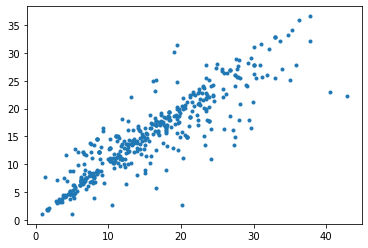

In [287]:
plt.plot(x,y,'.')

In [606]:
l.fit()

TypeError: fit() missing 2 required positional arguments: 'X' and 'y'

In [231]:
from sklearn.linear_model import LinearRegression

0.1782057360560888

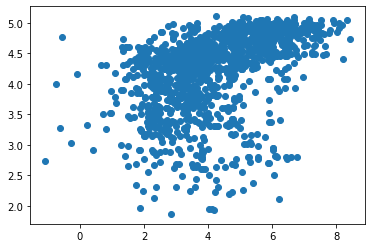

In [235]:
x = np.log(pd.to_numeric(a['slope_mean'],errors='coerce'))
y = np.log(pd.to_numeric(a['CRONUS Erosion Rate (m My)'],errors='coerce'))
I = np.where(np.logical_or(np.isnan(x.values),np.isnan(y.values)))[0]
x = x.drop(I).to_numpy()
y = y.drop(I).to_numpy()
l = LinearRegression().fit(x.reshape(-1,1),y.reshape(-1,1))
y_ = l.predict(x.reshape(-1,1))
plt.scatter(y,y_)

mt.r2_score(y, y_)

In [549]:
pt_gpd

,Unnamed: 0,Citation,Sample ID,Location,Latitude (decimal degrees),Longitude (decimal degrees),Mean Basin Elevation (m),Basin Relief (m),Basin Area (km ),Mean Latitude (decimal degrees),...,,type,dist,dist_bin,geometry,Basin_id,mean_topo,95_slope_mean,50_slope_mean,mean_slope_all
0,26,Belmont et al. (2007),Lower_EFMC,"Clearwater River, Washington, United States",47.654,-124.240,239.0,376,13.61,47.686,...,NaN,basinwide,133.065703,22,POINT (-124.24000 47.65400),7.090343e+09,341.127463,31.869465,inf,16.191463
1,525,Heimsath et al. (2001),OR-16,"Coast Range, Oregon, United States",43.469,-124.113,296.0,345,3.59,43.472,...,NaN,basinwide,131.505098,22,POINT (-124.11300 43.46900),7.090014e+09,95.408404,25.628412,inf,11.198064
2,460,NaN,ORK,"Redwood Creek at Orick, Coast Range, Californi...",41.289,-124.060,575.0,1619,720.45,41.060,...,NaN,basinwide,130.750392,22,POINT (-124.06000 41.28900),7.090014e+09,573.951708,26.369799,inf,16.075120
3,27,NaN,Upper_WC,NaN,47.739,-124.044,636.0,501,1.73,47.743,...,NaN,basinwide,132.913228,22,POINT (-124.04400 47.73900),7.090343e+09,341.127463,31.869465,inf,16.191463
4,28,NaN,Lower_WC,NaN,47.729,-124.037,563.0,606,4.22,47.746,...,NaN,basinwide,132.903103,22,POINT (-124.03700 47.72900),7.090343e+09,341.127463,31.869465,inf,16.191463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1385,530,NaN,NR-38,NaN,-36.667,150.000,1018.0,239,4.66,-36.636,...,NaN,basinwide,154.416543,26,POINT (150.00000 -36.66700),5.090072e+09,84.175025,14.424484,inf,7.204998
1386,531,NaN,NR-58,NaN,-36.667,150.000,919.0,864,23.17,-36.629,...,NaN,basinwide,154.416543,26,POINT (150.00000 -36.66700),5.090072e+09,84.175025,14.424484,inf,7.204998
1387,532,NaN,NR-60,NaN,-36.667,150.000,919.0,864,23.17,-36.629,...,NaN,basinwide,154.416543,26,POINT (150.00000 -36.66700),5.090072e+09,84.175025,14.424484,inf,7.204998
1388,528,Heimsath et al. (2006),NR-32,"Nunnock River Basin, Southeast Australia",-36.667,150.000,1005.0,251,5.98,-36.636,...,NaN,basinwide,154.416543,26,POINT (150.00000 -36.66700),5.090072e+09,84.175025,14.424484,inf,7.204998


[None, None]

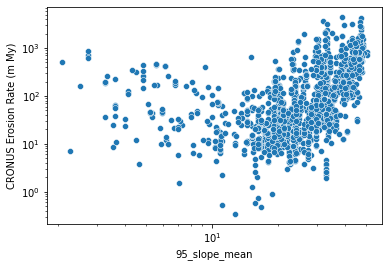

In [562]:
ax = sns.scatterplot(data=pt_gpd,x='95_slope_mean',y='CRONUS Erosion Rate (m My)')

ax.set(xscale="log", yscale="log")

[None, None]

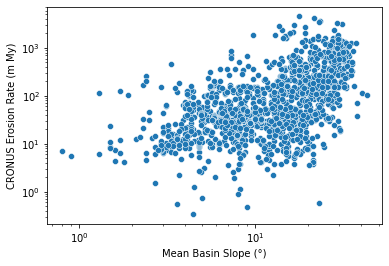

In [557]:
ax = sns.scatterplot(data=pt_gpd,x='Mean Basin Slope (°)',y='CRONUS Erosion Rate (m My)')
ax.set(xscale="log", yscale="log")